In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
# noise examples
fs = 4000

In [4]:
def noise_file_to_audio(noise_dir, sample_rate):
    effects = [
        ['remix', '1'],  # convert to mono
        ['rate', str(sample_rate)],  # resample
        ['gain', '-n']  # normalises to 0dB
    ]
    noise, sr = torchaudio.sox_effects.apply_effects_file(noise_dir, effects, normalize=True)
    return noise, sr

In [5]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

get_data_humpback = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

get_data_noise_humpback = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HUMPBACK_LABEL_A_NOISE,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

get_data_bowhead = get_data.GetDataBase(
    location_of_wav_file=constants.BOWHEAD_WAV_B,
    location_of_annotations=constants.BOWHEAD_LABELS_B,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

get_data_noise_bowhead = get_data.GetDataBase(
    location_of_wav_file=constants.BOWHEAD_WAV_B,
    location_of_annotations=constants.BOWHEAD_LABELS_B_NOISE,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

In [6]:
humpback_audio, _ = noise_file_to_audio(get_data_humpback.location_of_wav_file, 4000)
humpback_audio_numpy = humpback_audio.numpy().flatten()

bowhead_audio, _ = noise_file_to_audio(get_data_bowhead.location_of_wav_file, 4000)
bowhead_audio_numpy = bowhead_audio.numpy().flatten()

In [7]:
# log power seems to work better than magnitude
nfft = 256
def get_feature(sample, nfft):
    return np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))

In [9]:
# create labels and data
humpback_samples = []
humpback_features = []

for i in range(len(get_data_humpback.annotations.annotations)):
    annot = get_data_humpback.annotations.annotations[i]
    sample = humpback_audio_numpy[annot.start:annot.end]
    humpback_samples.append(sample)
    humpback_features.append(get_feature(sample, nfft))


In [10]:
noise_samples = []
noise_features = []

for i in range(len(get_data_noise_humpback.annotations.annotations)):
    annot = get_data_noise_humpback.annotations.annotations[i]
    sample = humpback_audio_numpy[annot.start:annot.end]
    noise_samples.append(sample)
    feature = get_feature(sample, nfft)
    noise_features.append(feature)

for i in range(len(get_data_noise_bowhead.annotations.annotations)):
    annot = get_data_noise_bowhead.annotations.annotations[i]
    sample = bowhead_audio_numpy[annot.start:annot.end]
    noise_samples.append(sample)
    feature = get_feature(sample, nfft)
    noise_features.append(feature)

In [11]:
bowhead_samples = []
bowhead_features = []

for i in range(len(get_data_bowhead.annotations.annotations)):
    annot = get_data_bowhead.annotations.annotations[i]
    sample = bowhead_audio_numpy[annot.start:annot.end]
    bowhead_samples.append(sample)
    feature = get_feature(sample, nfft)
    bowhead_features.append(feature)

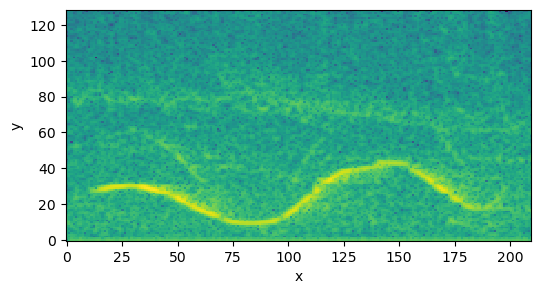

In [12]:
from final.useful import *
vis_helper(bowhead_features[10])

In [21]:
# train hmm noise

from hmmlearn.hmm import GaussianHMM
hmm_noise = GaussianHMM(4)
hmm_noise.fit(np.concatenate(noise_features))

hmm_humpback = GaussianHMM(3)
hmm_humpback.fit(np.concatenate(humpback_features))

hmm_bowhead = GaussianHMM(4)
hmm_bowhead.fit(np.concatenate(bowhead_features))

GaussianHMM(n_components=4)

In [14]:
hmm_noise.score(bowhead_features[5][0:200, :])

-57890.76257670024

In [15]:
hmm_humpback.score(bowhead_features[5][0:200, :])

-58378.581769345634

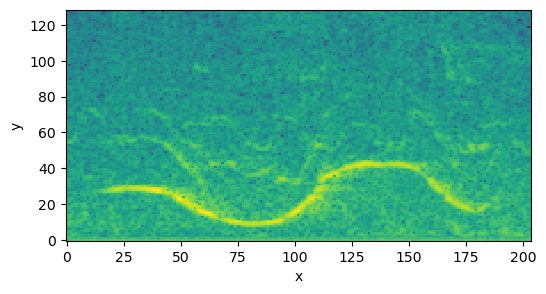

In [16]:
test_result = hmm_bowhead.decode(bowhead_features[5][0:200, :])
vis_helper(bowhead_features[5])

In [17]:
import scipy.stats as st
def distributions_js(distribution_p, distribution_q, n_samples=10 ** 5):
    # jensen shannon divergence. (Jensen shannon distance is the square root of the divergence)
    # all the logarithms are defined as log2 (because of information entrophy)
    X = distribution_p.rvs(n_samples)
    p_X = distribution_p.pdf(X)
    q_X = distribution_q.pdf(X)
    log_mix_X = np.log2(p_X + q_X)

    Y = distribution_q.rvs(n_samples)
    p_Y = distribution_p.pdf(Y)
    q_Y = distribution_q.pdf(Y)
    log_mix_Y = np.log2(p_Y + q_Y)

    return (np.log2(p_X).mean() - (log_mix_X.mean() - np.log2(2))
            + np.log2(q_Y).mean() - (log_mix_Y.mean() - np.log2(2))) / 2

def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.rvs(n_samples)
    log_p_X = gmm_p.logpdf(X)
    log_q_X = gmm_q.logpdf(X)
    return log_p_X.mean() - log_q_X.mean()

In [22]:
def find_similar_states_kl(hmm1, hmm2):
    # Adjust the threshold based on your similarity criterion

    dict_js = np.zeros((hmm1.n_components,hmm2.n_components))
    # Iterate through states in hmm_whale
    for i in range(hmm1.n_components):
        # Iterate through states in hmm_noise
        for j in range(hmm2.n_components):
            # Calculate KL divergence between the distributions of means and covariances
            gmm_1 = st.multivariate_normal(hmm1.means_[i],hmm1.covars_[i])
            gmm_2 = st.multivariate_normal(hmm2.means_[j],hmm2.covars_[j])

            kl_div = gmm_kl(gmm_1, gmm_2)
            dict_js[i,j]  = kl_div
    return dict_js

find_similar_states_kl(hmm_bowhead, hmm_noise)

array([[162.41759149,  14.56337923, 196.23553242,   7.42961664],
       [255.43967718,  36.35627159, 305.18872211,  41.92746575],
       [297.07080194,  54.69223427, 343.39710841,  48.68137507],
       [331.69942849,  59.11232388, 383.89494806,  64.0303903 ]])

In [23]:
def delete_component(hmm1, component_to_delete):
    # Remove the component_to_delete
    print('deleting comp', component_to_delete)
    new_hmm = GaussianHMM(n_components=hmm1.n_components - 1, covariance_type=hmm1.covariance_type)
    new_hmm.n_features = hmm1.n_features
    transmat_ = np.delete(hmm1.transmat_, component_to_delete, axis=0)
    transmat_ = np.delete(transmat_, component_to_delete, axis=1)
    new_hmm.transmat_ = transmat_ / np.sum(transmat_, axis=1, keepdims=True)  # Normalization along axis=1

    startprob_ = np.delete(hmm1.startprob_, component_to_delete)
    new_hmm.startprob_ = startprob_ / np.sum(startprob_, axis=0, keepdims=True)  # Normalization along axis=1

    new_hmm.means_ = np.delete(hmm1.means_, component_to_delete, axis=0)

    covars_ = np.delete(hmm1.covars_, component_to_delete, axis=0)

    new_hmm.covars_ = np.array([np.diag(i) for i in covars_])

    return new_hmm

hmm_bowhead_updated = delete_component(hmm_bowhead, 0)

deleting comp 0


In [24]:
find_similar_states_kl(hmm_bowhead_updated, hmm_noise)

array([[255.55660575,  36.34725637, 305.35500133,  41.87297248],
       [296.91312336,  54.71027536, 343.34797643,  48.66472217],
       [331.56468634,  59.14629369, 384.29454753,  64.05242381]])

In [25]:
# append and create labels - this should be with samples earlier

complete_data = []
complete_labels = []
for i in range(len(humpback_features)):
    complete_data.append(humpback_features[i])
    complete_labels.append(np.zeros(len(humpback_features[i])))

for i in range(len(bowhead_features)):
    complete_data.append(bowhead_features[i])
    complete_labels.append(np.ones(len(bowhead_features[i])))

for i in range(len(noise_features)):
    complete_data.append(noise_features[i])
    complete_labels.append(np.ones(len(noise_features[i])) * 2)


In [26]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

<module 'final.cross_validation' from '/Users/david/Documents/mastersCode/ubm/final/cross_validation.py'>

In [27]:
n_folds = 2
cv_output = cv.split_data_for_cross_validation(complete_data, complete_labels, n_folds)

In [28]:
from sklearn.metrics import accuracy_score
import final.models.decode_combine as dc

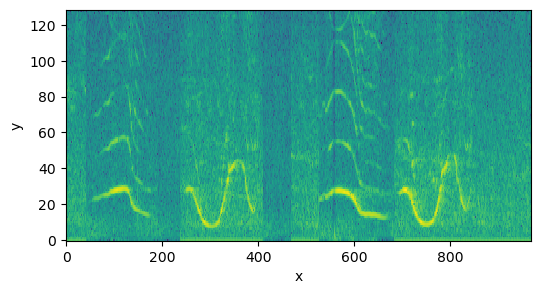

In [88]:
combine_test = np.concatenate((noise_features[-1], humpback_features[5], noise_features[8], bowhead_features[4], noise_features[2], noise_features[-2], humpback_features[-1], bowhead_features[6], noise_features[-3]), axis=0)
vis_helper(combine_test)
# vis_helper(humpback_features[5])
# vis_helper(bowhead_features[4])

In [89]:
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm_humpback, hmm_bowhead_updated, hmm_noise])

In [90]:
states, labels, log_prob = combined_model.decode(combine_test)

calculating emission matrix
viterbi_algorithm


In [95]:
def smooth_labels(labels, window_size=50, step_size=10):

    smoothy_labels = labels.copy()
    arg_max = []
    arg_max_index = []

    for start in range(0, len(labels) - window_size + 1, step_size):
        end = start + window_size
        window = labels[start:end]

        unique_elements, counts = np.unique(window, return_counts=True)
        max_count_index = np.argmax(counts)
        dominant_label = unique_elements[max_count_index]
        arg_max.append(dominant_label)
        arg_max_index.append(start)

    changes = []
    changes_index = []
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            changes.append(labels[i])
            changes_index.append(i)

    fwd = changes[2]
    curr = changes[1]
    prev = changes[0]
    for i in range(2, len(changes)):
        fwd = changes[i]
        curr = changes[i-1]
        prev = changes[i-2]
        index_curr = changes_index[i-1]
        index_fwd = changes_index[i]
        diff = index_fwd - index_curr
        if diff < 15:
            print('possible quick switch')
            arg_max_index_cur = np.argmin(np.abs(np.array(arg_max_index) - index_curr))
            arg_max_index_fwd = np.argmin(np.abs(np.array(arg_max_index) - index_fwd))
            if(
                arg_max[arg_max_index_cur] == arg_max[arg_max_index_fwd]
            ):
                print('quick switch')
                smoothy_labels[index_curr: index_fwd] = np.ones(diff) * fwd
            # if diff is small and average is index fwd then

            # print(diff)
    return smoothy_labels

smoothed_labels = smooth_labels(labels)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch
quick switch


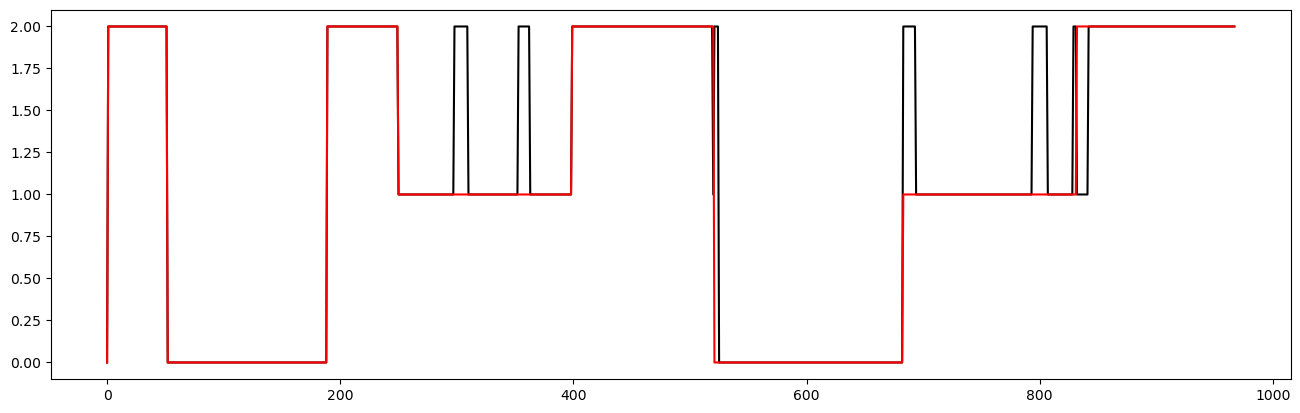

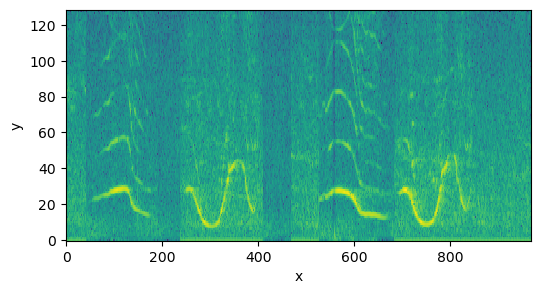

In [96]:
# plt.plot(states)
import matplotlib.pyplot as plt
plt.plot(labels, c='black')
plt.plot(smoothed_labels, c='red')
vis_helper(combine_test)

In [97]:
label_mapping = {
    0: 'H',
    1: 'B',
    2: 'N',
}

def find_label_changes(labels, dict):
    changes = []
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            changes.append((i, dict[labels[i]]))
    return changes

label_changes = find_label_changes(smoothed_labels, label_mapping)

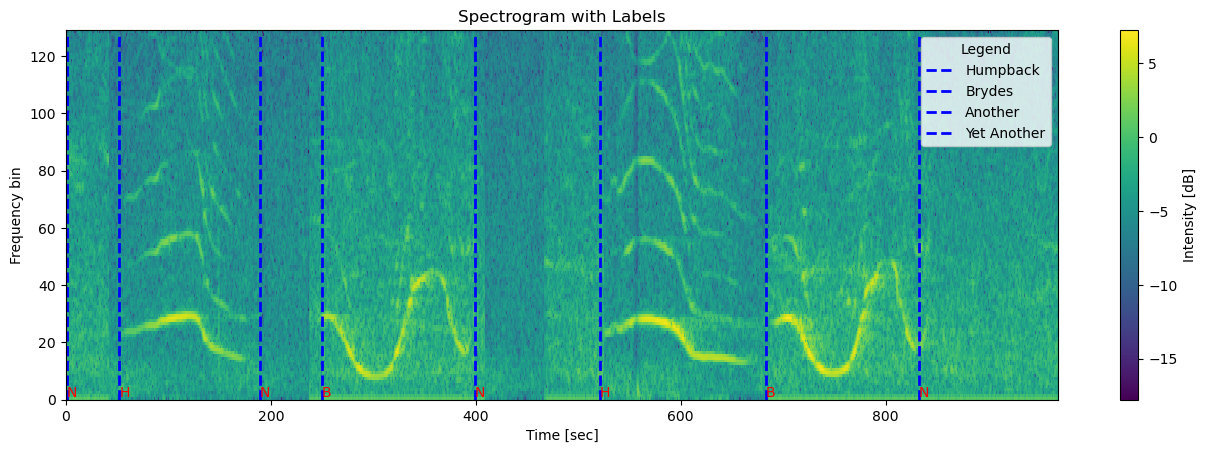

In [98]:
# Sample data and labels
# Replace this with your actual data and labels
# features = np.random.rand(1000)  # Replace with your actual features
labels_at_indices = [(100, 'A'), (300, 'B'), (500, 'C')]

times = np.arange(combine_test.shape[0])
frequencies = np.arange(combine_test.shape[1])

# Create a spectrogram
labels_Alph = ['A', 'B', 'C', 'D']
label_names = {'A': 'Humpback', 'B': 'Brydes', 'C': 'Another', 'D': 'Yet Another'}
label_indices = [10, 30, 50, 70]

plt.pcolormesh(combine_test.T)
plt.ylabel('Frequency bin')
plt.xlabel('Time [sec]')

for index, label in label_changes:
    plt.text(times[index], frequencies[0], label, color='red', fontsize=10, verticalalignment='bottom')
    plt.vlines(times[index], ymin=frequencies.min(), ymax=frequencies.max(), color='blue', linestyles='dashed', linewidth=2)

# plt.vlines(times[label_indices], ymin=frequencies.min(), ymax=frequencies.max(), color='blue', linestyles='dashed', linewidth=2)

legend_labels = [label_names[label] for label in labels_Alph]
plt.legend(legend_labels, loc='upper right', title='Legend')
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram with Labels')
plt.show()

KeyboardInterrupt: 

In [66]:
# metrics

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return_metrics = {
        'acc': ACC,
        'tpr': TPR,
        'fpr': FPR
    }

    return return_metrics


In [78]:
import sklearn.metrics
n_comp = 4
acc = []
acc_v2 = []
for i in range(n_folds):
    n_fold_whale_hmm = GaussianHMM(n_comp)
    whale_indexes = np.concatenate(cv_output['train_label'][i]) == 1
    whale_data = np.concatenate(cv_output['train_data'][i])
    whale_data = whale_data[whale_indexes, :]
    n_fold_whale_hmm.fit(whale_data)
    combined = dc.DecodeCombineGaussian([n_fold_whale_hmm, hmm_noise])
    states, y_pred, log_prob = combined_model.decode(np.concatenate(cv_output['val_data'][i]))
    y_true = np.concatenate(cv_output['val_label'][i])
    acc.append(accuracy_score(y_true, y_pred))
    acc_v2.append(perf_measure(y_true, y_pred))

calculating emission matrix
viterbi_algorithm
calculating emission matrix
viterbi_algorithm


In [79]:
print(np.mean(acc))

0.8223294750678507


In [ ]:
my_hmm = GaussianHMM(2)
my_hmm.score_samples()